In [1]:
import tensorflow as tf
import numpy as np
from pathlib import Path
import gzip
import os

2023-03-20 16:37:04.336135: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 16:37:05.005823: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/dist/plumed2/src/lib/:/opt/gromacs/lib:/home/dima/miniconda3/envs/tf/lib/
2023-03-20 16:37:05.005884: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/dist/plumed2/src/lib/:/opt/gromacs/l

In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
from run_opts import config_runtime
from src.logger import Logger
from dataset import read_list

# Read and prepare

In [5]:
n_cls = 3  # number of classes
# conf_dev = config_runtime['device']
train_f = config_runtime['train_frac']
seed = config_runtime['seed']
learning_rate = config_runtime['learning_rate']
batch_size = config_runtime['batch_size']
hid_size = config_runtime['hidden_size']
log_step = config_runtime['log_step']
epochs = config_runtime['num_epochs']
run_name = config_runtime['run_name']
hid_size = 32

In [6]:
logger = Logger("./", "train")

# store parameters
logger.print("Parameters")
logger.print("-------------------------")
logger.print(f"Train fraction:    {train_f}")
logger.print(f"Learning rate:     {learning_rate}")
logger.print(f"Batch size:        {batch_size}")
logger.print(f"Hidden layer size: {hid_size}")
logger.print(f"Number of epochs:  {epochs}")
logger.print("-------------------------")

Parameters
-------------------------
Train fraction:    0.74
Learning rate:     0.001
Batch size:        512
Hidden layer size: 32
Number of epochs:  75
-------------------------


In [7]:
# Read list of the proteins
proteins = []
with open("../../data/lists/train_logp.txt", 'r') as iFile:
    for i in iFile:
        if i[0] != '#':
            proteins.append(i.strip())

In [14]:
train_prots, test_prots = train_test_split(proteins, train_size=0.2, random_state=342)

In [15]:
print(train_prots, test_prots)

['3AAA_A'] ['1GP2_B', '4k12_A', '1bx7_A', '3onh_A', '2IXT_AB', '2OOR_A', '3FCG_B', '7R2H_A']


In [16]:
_, feat, logp = read_list(train_prots)
X_train = feat
y_train = logp
_, feat, logp = read_list(test_prots)
X_val = feat
y_val = logp

In [17]:
n_input = feat.shape[1]

In [118]:
X_train.shape

(13884, 106)

# Model

In [184]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(n_input, activation='relu'),
    tf.keras.layers.Dense(hid_size, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(hid_size, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(hid_size, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(hid_size, activation='relu'),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(hid_size, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(hid_size, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(n_cls)
])

In [185]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.load_weights("./model/model.ckpt")
# 


In [186]:
model.trainable = False

In [187]:
model.layers[-1].trainable = True
model.layers[-2].trainable = True

In [188]:
_, X_train_sub, _, y_train_sub = train_test_split(X_train, y_train, test_size=0.02, random_state=42)

print(X_train_sub.shape, y_train_sub.shape)

(278, 106) (278,)


In [189]:
model.fit(
    X_train_sub, y_train_sub,
    batch_size=64,
    epochs=25,
    validation_data=(X_val, y_val))

Epoch 1/25
5/5 [==============================] - 3s 310ms/step - loss: 0.6778 - accuracy: 0.7338 - val_loss: 0.8039 - val_accuracy: 0.6316
Epoch 2/25
5/5 [==============================] - 1s 275ms/step - loss: 0.6063 - accuracy: 0.7986 - val_loss: 0.8162 - val_accuracy: 0.6115
Epoch 3/25
5/5 [==============================] - 1s 275ms/step - loss: 0.5457 - accuracy: 0.8094 - val_loss: 0.8236 - val_accuracy: 0.6077
Epoch 4/25
5/5 [==============================] - 1s 282ms/step - loss: 0.4745 - accuracy: 0.8633 - val_loss: 0.8382 - val_accuracy: 0.6106
Epoch 5/25
5/5 [==============================] - 1s 279ms/step - loss: 0.4265 - accuracy: 0.8597 - val_loss: 0.8721 - val_accuracy: 0.6103
Epoch 6/25
5/5 [==============================] - 1s 280ms/step - loss: 0.3722 - accuracy: 0.8885 - val_loss: 0.9428 - val_accuracy: 0.6085
Epoch 7/25
5/5 [==============================] - 1s 272ms/step - loss: 0.3374 - accuracy: 0.8885 - val_loss: 1.0632 - val_accuracy: 0.6041
Epoch 8/25
5/5 [====

# Plot for presentation

In [182]:
model.history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [191]:
epochs =np.arange(25) + 1

In [183]:
# without transfer learning
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

In [190]:
#with transfer learning
acc1 = model.history.history['accuracy']
val_acc1 = model.history.history['val_accuracy']

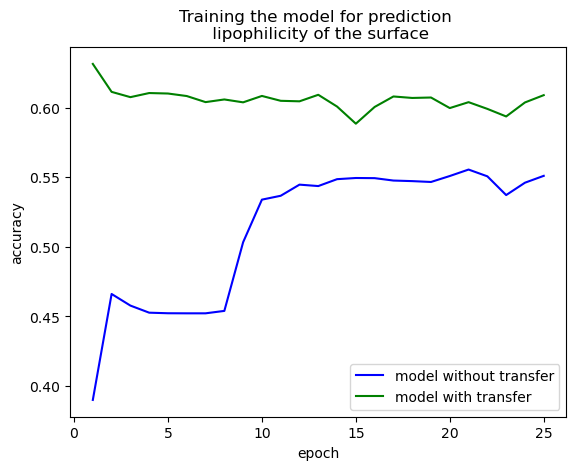

In [202]:
# plt.plot(epochs, acc, c = 'blue')
# plt.plot(epochs, acc1, c = 'green')

plt.plot(epochs, val_acc, c = 'blue', label = 'model without transfer')
plt.plot(epochs, val_acc1, c = 'green', label = 'model with transfer')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Training the model for prediction \n lipophilicity of the surface")
plt.legend()
